In [24]:
import uncertainties
from uncertainties.umath import * # sin(), etc.
from uncertainties import ufloat
from uncertainties import unumpy, umath
import math
from scipy.optimize import minimize
from scipy import stats
import math
from autograd import hessian
import autograd.numpy as np
import glob
from matplotlib import pyplot as plt

In [25]:
import os
result_files = []
failed_files = []
for i in range(1,1001):
    result_file = f"/shared/scratch/pc24403/sim_fit_check_each/simfit_output_{i}.txt"
    if os.path.exists(result_file):
        with open(result_file) as f:
            content = f.read()    
            result_files.append(result_file)
    else:
        failed_files.append(i)

print(f"Found {len(result_files)} valid results")

Found 863 valid results


In [26]:

foundCKM = False
idx_CKM = 0
cov_string = ""
param_string = ""
log_strings = []
xp = []
xm = []
yp = []
ym = []
xxi = []
yxi = []


for result_file in result_files:
    do_next = True
    idx = 0
    idxs = []
    x = []
    dx = []
    cov = []
    with open(result_file) as f: 
        for l in f:
            for i_dex in range(0,6):
                if f"│ {i_dex} │ x{i_dex} " in l:
                    a = l.split()
                    value = float(a[5])
                    x += [value]
                    error = float(a[7])
                    dx += [error]
                    idxs += [idx]
                    idx +=1
            log_strings += [l.replace("\n", "")]
    for check_idx in range(0, 6):
        if abs(x[check_idx])> 1:
            do_next=False
            continue
    
    if do_next ==False: continue
    xp.append(ufloat(x[0], dx[0]))
    xm.append(ufloat(x[2], dx[2]))
    yp.append(ufloat(x[1], dx[1]))
    ym.append(ufloat(x[3], dx[3]))
    xxi.append(ufloat(x[4], dx[4]))
    yxi.append(ufloat(x[5], dx[5]))

In [27]:
x_exp = [-0.0897, -0.0110, 0.0586, 0.0688, -0.0549, 0.0070]

In [28]:
xp_pull = []
yp_pull = []
xm_pull = []
ym_pull = []
xxi_pull = []
yxi_pull = []

for i in range(len(xp)):
    xp_pull.append((xp[i].n-x_exp[0])/xp[i].s)
    yp_pull.append((yp[i].n-x_exp[1])/yp[i].s)
    xm_pull.append((xm[i].n-x_exp[2])/xm[i].s)
    ym_pull.append((ym[i].n-x_exp[3])/ym[i].s)
    xxi_pull.append((xxi[i].n-x_exp[4])/xxi[i].s)
    yxi_pull.append((yxi[i].n-x_exp[5])/yxi[i].s)


Text(0.5, 0.5, 'mean: 0.08\nstd: 1.0')

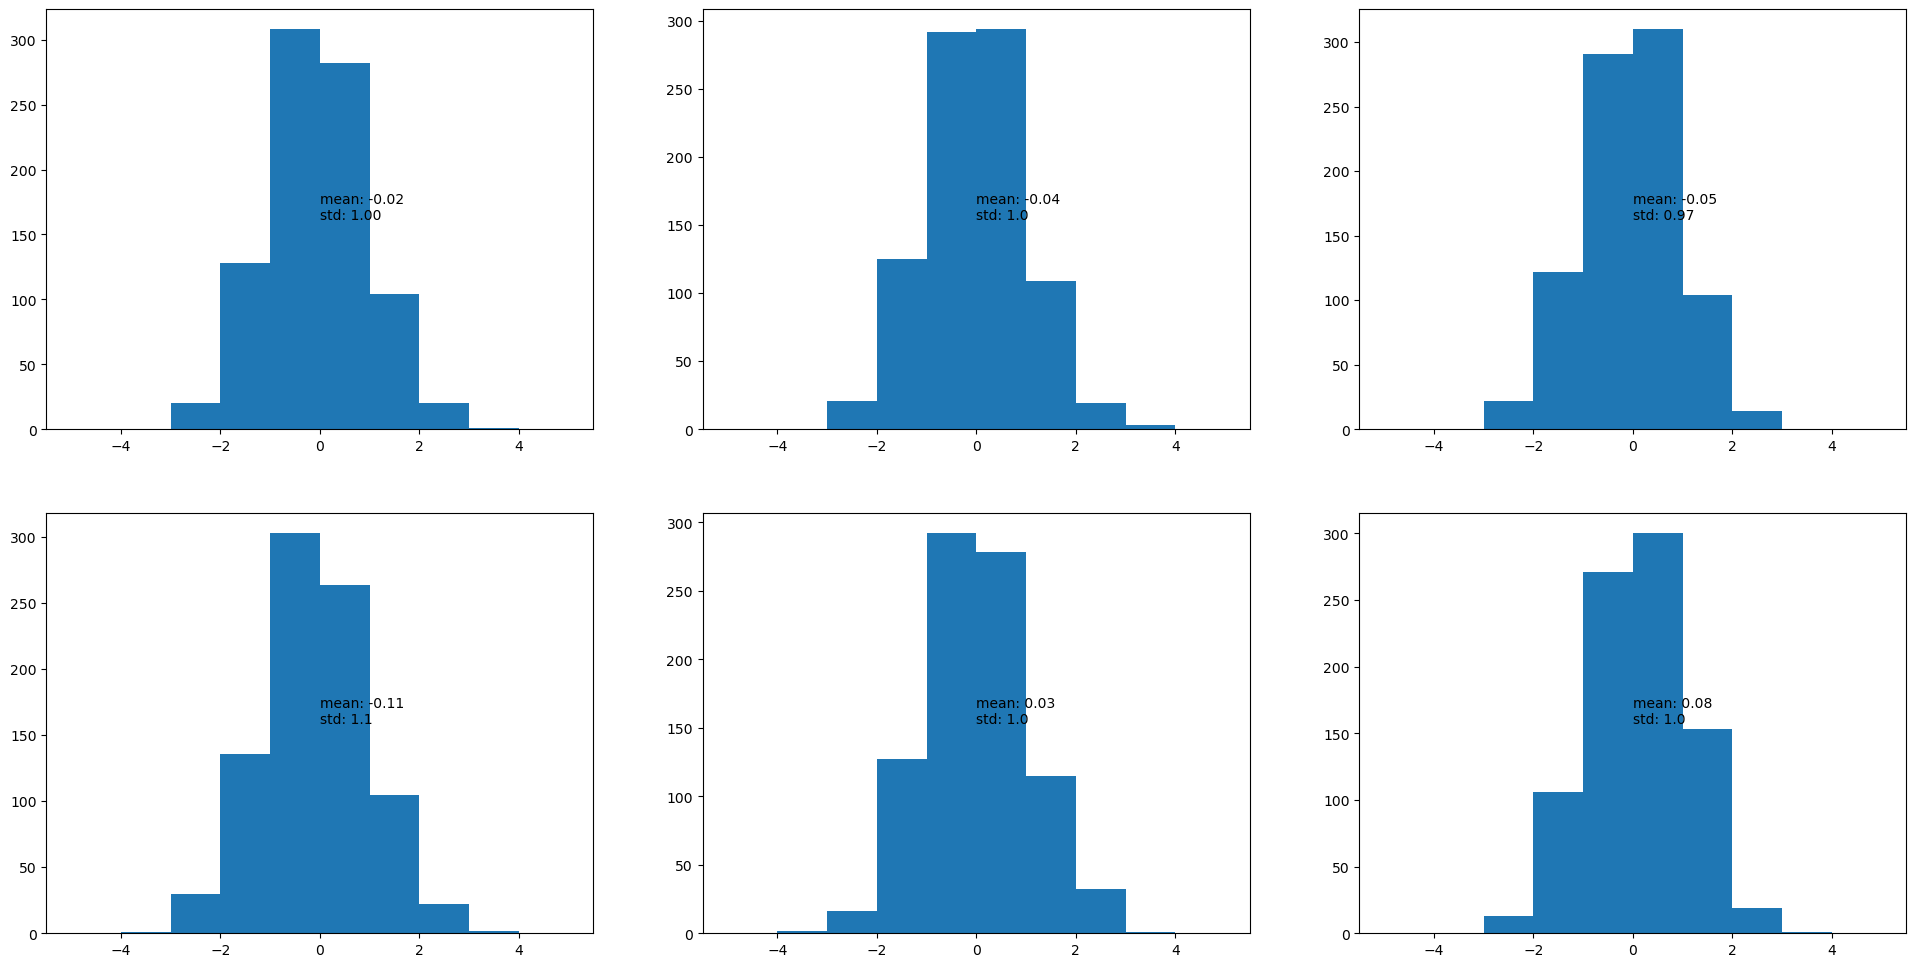

In [29]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(8*3, 6*2))

ax1.hist(xp_pull, bins=10, range=(-5, 5), label="x+")
ax1.text(0.5, 0.5, f"mean: {np.mean(xp_pull):.2f}\nstd: {np.std(xp_pull):.2f}", transform=ax1.transAxes)

ax2.hist(yp_pull, bins=10, range=(-5, 5), label="y+")
ax2.text(0.5, 0.5, f"mean: {np.mean(yp_pull):.2f}\nstd: {np.std(yp_pull):.2}", transform=ax2.transAxes)

ax3.hist(xm_pull, bins=10, range=(-5, 5), label="x-")
ax3.text(0.5, 0.5, f"mean: {np.mean(xm_pull):.2f}\nstd: {np.std(xm_pull):.2}", transform=ax3.transAxes)

ax4.hist(ym_pull, bins=10, range=(-5, 5), label="y-")
ax4.text(0.5, 0.5, f"mean: {np.mean(ym_pull):.2f}\nstd: {np.std(ym_pull):.2}", transform=ax4.transAxes)

ax5.hist(xxi_pull, bins=10, range=(-5, 5), label="xxi")
ax5.text(0.5, 0.5, f"mean: {np.mean(xxi_pull):.2f}\nstd: {np.std(xxi_pull):.2}", transform=ax5.transAxes)

ax6.hist(yxi_pull, bins=10, range=(-5, 5), label="yxi")
ax6.text(0.5, 0.5, f"mean: {np.mean(yxi_pull):.2f}\nstd: {np.std(yxi_pull):.2}", transform=ax6.transAxes)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2455                       │              Nfcn = 34               │
│ EDM = 2.18e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

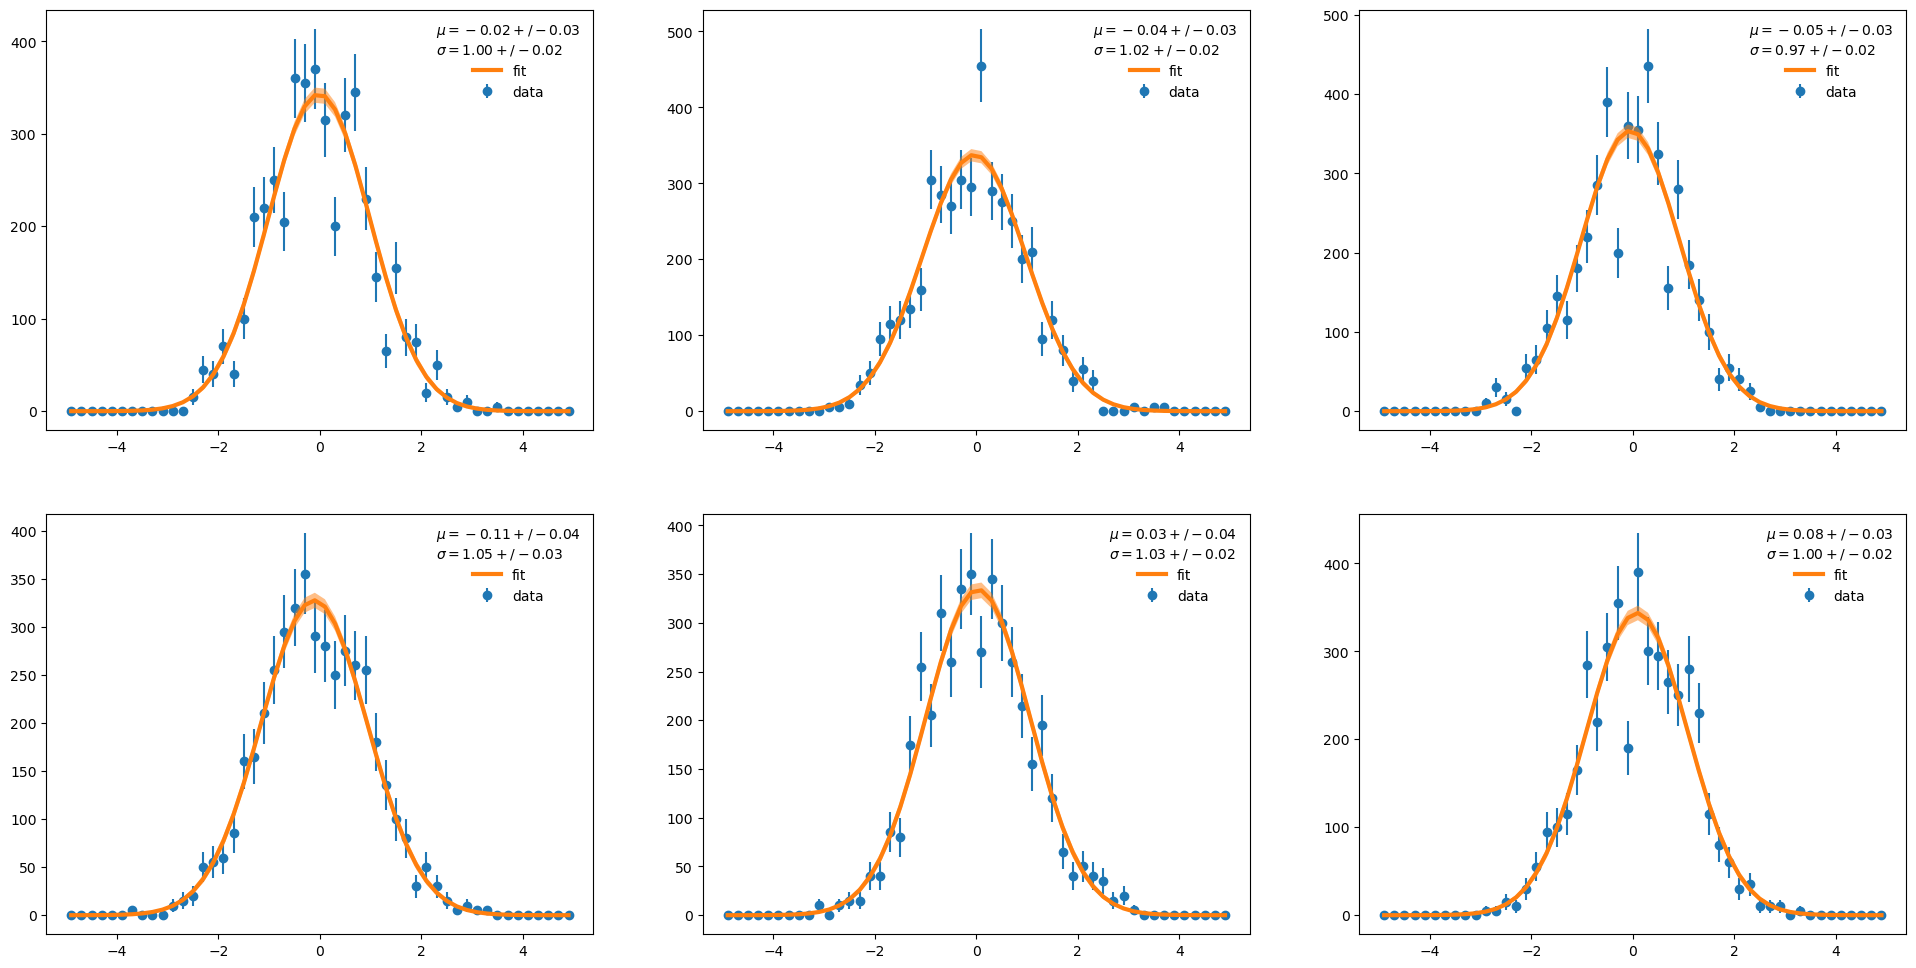

In [30]:
#Fit with Gaussian with iminuit
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL

ax= [ax1, ax2, ax3, ax4, ax5, ax6]

fig, ((ax[0], ax[1], ax[2]), (ax[3], ax[4], ax[5])) = plt.subplots(2, 3, figsize=(8*3, 6*2))
i=0
for data in [xp_pull, yp_pull, xm_pull, ym_pull, xxi_pull, yxi_pull]:
    def pdf(x, p):
        mu=p[0]
        sigma=p[1]
        return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2))
    
    c = UnbinnedNLL(data, pdf)
    
    m = Minuit(c, (0, 1))
    m.migrad()
    m.hesse()
    print(m)
    
    w, xe = np.histogram(data, bins=50, range=(-5, 5))
    
    # compute bin-wise density estimates
    werr = w ** 0.5
    cx = 0.5 * (xe[1:] + xe[:-1])
    dx = np.diff(xe)
    d = w / dx
    derr = werr / dx
    #m.visualize()
    # plot everything
    from jacobi import propagate

    # run error propagation
    y, ycov = propagate(lambda p: len(xp_pull)*pdf(cx, p), m.values, m.covariance)

    # plot everything
    ax[i].errorbar(cx, d, derr, fmt="o", label="data", zorder=0)

    ax[i].plot(cx, y, lw=3, label="fit")

    # draw 1 sigma error band
    yerr_prop = np.diag(ycov) ** 0.5
    ax[i].fill_between(cx, y - yerr_prop, y + yerr_prop, facecolor="C1", alpha=0.5)

    ax[i].legend(frameon=False,
           title=f"$\mu = {m.values[0]:.2f} +/- {m.errors[0]:.2f}$\n"
                 f"$\sigma = {m.values[1]:.2f} +/- {m.errors[1]:.2f}$");



#    ax[i].errorbar(cx, d, derr, fmt="o", label="data", zorder=0)
#    ax[i].plot(cx, len(xp_pull)*pdf(cx, m.values[0], m.values[1]), lw=3,
#         label="fit")
#    ax[i].legend(frameon=False,
#           title=f"$\mu = {m.values[0]:.2f} +/- {m.errors[0]:.2f}$\n"
#                 f"$\sigma = {m.values[1]:.2f} +/- {m.errors[1]:.2f}$");
    i+=1

In [31]:
xp_res = []
yp_res = []
xm_res = []
ym_res = []
xxi_res = []
yxi_res = []

for i in range(len(xp)):
    xp_res.append((xp[i].n-x_exp[0]))
    yp_res.append((yp[i].n-x_exp[1]))
    xm_res.append((xm[i].n-x_exp[2]))
    ym_res.append((ym[i].n-x_exp[3]))
    xxi_res.append((xxi[i].n-x_exp[4]))
    yxi_res.append((yxi[i].n-x_exp[5]))


Text(0.5, 0.5, 'mean: 0.00\nstd: 0.02')

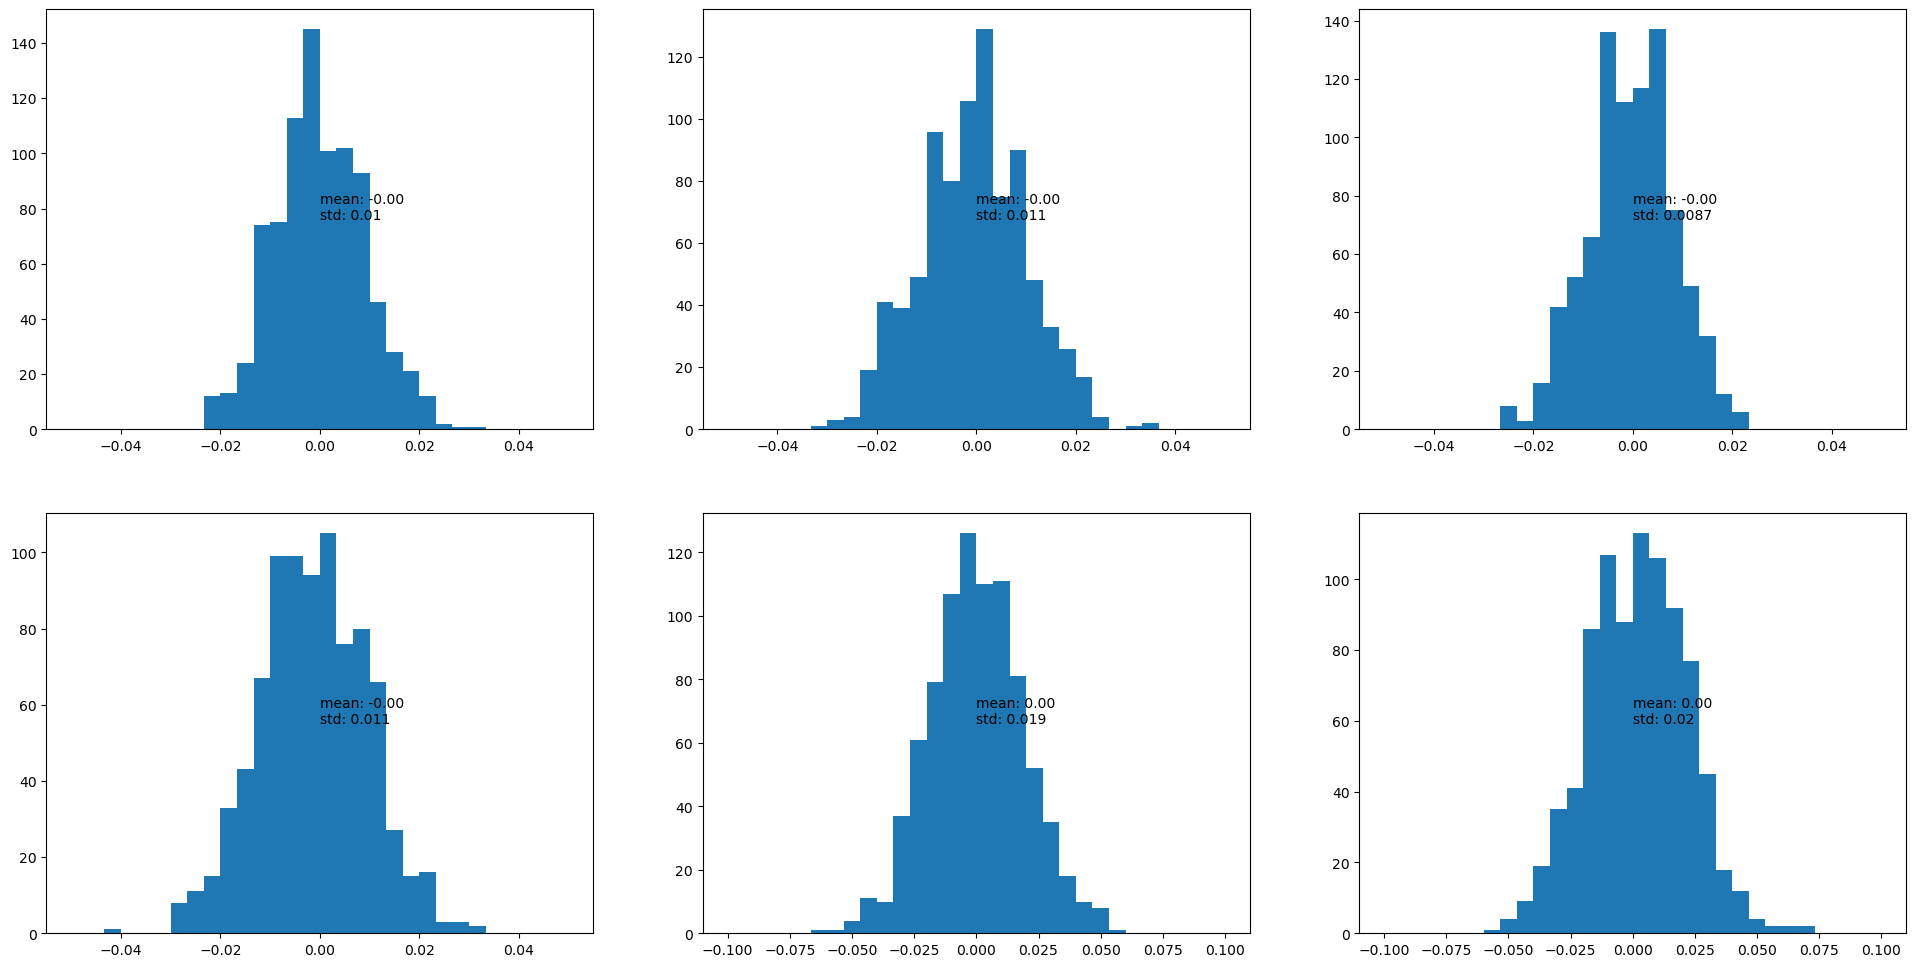

In [32]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(8*3, 6*2))

ax1.hist(xp_res, bins=30, range=(-0.05, 0.05), label="x+")
ax1.text(0.5, 0.5, f"mean: {np.mean(xp_res):.2f}\nstd: {np.std(xp_res):.2f}", transform=ax1.transAxes)

ax2.hist(yp_res, bins=30, range=(-0.05, 0.05), label="y+")
ax2.text(0.5, 0.5, f"mean: {np.mean(yp_res):.2f}\nstd: {np.std(yp_res):.2}", transform=ax2.transAxes)

ax3.hist(xm_res, bins=30, range=(-0.05, 0.05), label="x-")
ax3.text(0.5, 0.5, f"mean: {np.mean(xm_res):.2f}\nstd: {np.std(xm_res):.2}", transform=ax3.transAxes)

ax4.hist(ym_res, bins=30, range=(-0.05, 0.05), label="y-")
ax4.text(0.5, 0.5, f"mean: {np.mean(ym_res):.2f}\nstd: {np.std(ym_res):.2}", transform=ax4.transAxes)

ax5.hist(xxi_res, bins=30, range=(-0.1, 0.1), label="xxi")
ax5.text(0.5, 0.5, f"mean: {np.mean(xxi_res):.2f}\nstd: {np.std(xxi_res):.2}", transform=ax5.transAxes)

ax6.hist(yxi_res, bins=30, range=(-0.1, 0.1), label="yxi")
ax6.text(0.5, 0.5, f"mean: {np.mean(yxi_res):.2f}\nstd: {np.std(yxi_res):.2}", transform=ax6.transAxes)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -5668                      │              Nfcn = 43               │
│ EDM = 1.53e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

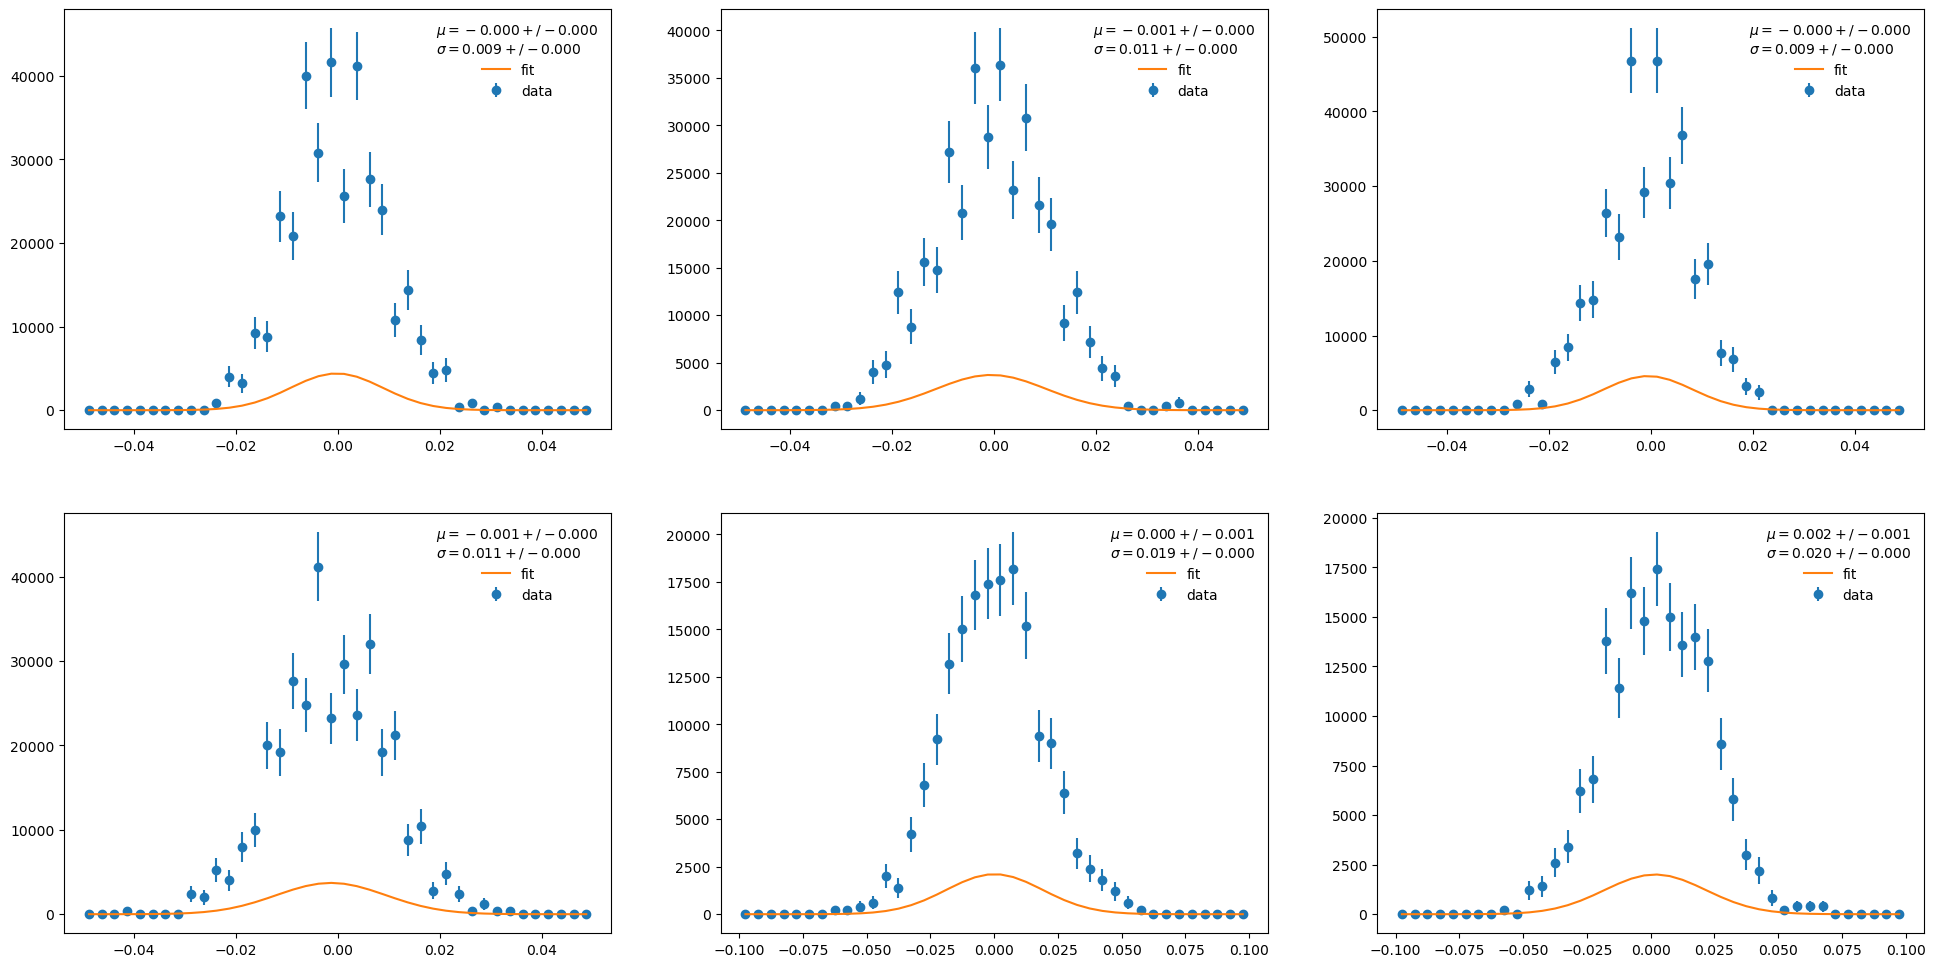

In [33]:
#Fit with Gaussian with iminuit
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL

ax= [ax1, ax2, ax3, ax4, ax5, ax6]
bound = [0.05, 0.05, 0.05, 0.05, 0.1, 0.1]

fig, ((ax[0], ax[1], ax[2]), (ax[3], ax[4], ax[5])) = plt.subplots(2, 3, figsize=(8*3, 6*2))
i=0
for data in [xp_res, yp_res, xm_res, ym_res, xxi_res, yxi_res]:
    def pdf(x, mu, sigma):
        return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2))
    
    c = UnbinnedNLL(data, pdf)
    
    m = Minuit(c, mu=0, sigma=0.01)
    m.migrad()
    m.hesse()
    print(m)
    
    w, xe = np.histogram(data, bins=40, range=(-bound[i], bound[i]))
    
    # compute bin-wise density estimates
    werr = w ** 0.5
    cx = 0.5 * (xe[1:] + xe[:-1])
    dx = np.diff(xe)
    d = w / dx
    derr = werr / dx
    #m.visualize()
# plot everything


    ax[i].errorbar(cx, d, derr, fmt="o", label="data", zorder=0)
    ax[i].plot(cx, 100*pdf(cx, m.values[0], m.values[1]),
         label="fit")
    ax[i].legend(frameon=False,
           title=f"$\mu = {m.values[0]:.3f} +/- {m.errors[0]:.3f}$\n"
                 f"$\sigma = {m.values[1]:.3f} +/- {m.errors[1]:.3f}$");
    i+=1

In [34]:

foundCKM = False
idx_CKM = 0
cov_string = ""
param_string = ""
log_strings = []
cov = []


for result_file in result_files:
    idx = 0
    cov_temp = []
    with open(result_file) as f:
        for l in f:
            for i_dex in range(0,6):
                if f"│  x{i_dex} │" in l:
                    a = l.split()
                    cov_CKM_row = []
                    for j_dex in range(0,6):
                        cov_CKM_row += [float(a[3+j_dex])]
                    cov_temp += [cov_CKM_row]

            log_strings += [l.replace("\n", "")]
        cov += cov_temp[0:6]



X = []
for i in range(len(xp)):
    X += [[xp[i].n, yp[i].n, xm[i].n, ym[i].n, xxi[i].n, yxi[i].n]]


In [35]:
x[0]

-0.085

In [36]:
print(cov[6:12])

[[7.72e-05, 1.44e-05, -5.54e-07, -7.94e-07, -2.11e-05, -8.79e-06], [1.44e-05, 0.000103, 2.58e-06, -2.4e-06, 3.7e-06, -2.15e-05], [-5.54e-07, 2.58e-06, 7.55e-05, -1.47e-05, 1.53e-05, -2.89e-05], [-7.94e-07, -2.4e-06, -1.47e-05, 0.000107, -1.19e-07, 3.07e-05], [-2.11e-05, 3.7e-06, 1.53e-05, -1.19e-07, 0.000241, 1.71e-05], [-8.79e-06, -2.15e-05, -2.89e-05, 3.07e-05, 1.71e-05, 0.000279]]


In [37]:

def deg_to_rad(deg):
    return deg*np.pi/180

def rad_to_deg(rad):
    return rad*180/np.pi

def get_correlation_matrix(cov_matrix):
    corr_matrix = cov_matrix*0
    n = np.shape(cov_matrix)[0]
    for i in range(0, n):
        for j in range(0, n):
            corr_matrix[i, j] = cov_matrix[i, j]/math.sqrt(cov_matrix[i, i]*cov_matrix[j, j])
    return corr_matrix

def add_fit_result_details(res, data, H):
    
    # add the same results as in the yield fits
    ndf = len(data)-6
    res.p_value = 1 - stats.chi2.cdf(2*res.fun, ndf)

    res.H = H

    res.cov_mat = np.linalg.inv(res.H)
    try:
        res.cor_mat = get_correlation_matrix(res.cov_mat)
    except ValueError:
        # something went wrong when inverting
        # negative elements in covariance matrix diag
        # don't trust results
        res.success = False
        res.cor_mat = 0 * H
    res.x_unc = np.sqrt(np.diag(res.cov_mat))

    # translate to degrees; 1st save raw results
    res.raw_x = np.copy(res.x)
    res.raw_x_unc = np.copy(res.x_unc)

    # ensure angles are positive
    while res.x[0] < 0: res.x[0] += 2*math.pi
    while res.x[2] < 0: res.x[2] += 2*math.pi

    for i in range(len(res.x)):
        if (i % 2) == 0:
            # every other result is an angle, so apply rad_to_deg
            res.x[i] = rad_to_deg(res.x[i])
            res.x_unc[i] = rad_to_deg(res.x_unc[i])

    return res

In [38]:
# Chi2 residual for Parameters to fit: r, delta, gamma

def xm(rB, deltaB, gamma):
    xm = rB*np.cos(deltaB - gamma)
    return xm

def xp(rB, deltaB, gamma):
    xp = rB*np.cos(deltaB + gamma)
    return xp

def ym(rB, deltaB, gamma):
    ym = rB*np.sin(deltaB - gamma)
    return ym

def yp(rB, deltaB, gamma):
    yp = rB*np.sin(deltaB + gamma)
    return yp

def x_xi(rB, deltaB, rB_DPi, deltaB_DPi):
    x_xi = rB_DPi/rB*np.cos(deltaB_DPi - deltaB)
    return x_xi

def y_xi(rB, deltaB, rB_DPi, deltaB_DPi):
    y_xi = rB_DPi/rB*np.sin(deltaB_DPi - deltaB)
    return y_xi

def get_xy_xi(physics_param):
    ''' takes an input vector with [gamma, rB, deltaB] and returns x, y
    angles in RADIANS
    '''
    gamma  = physics_param[0]
    r_dk   = physics_param[1]
    d_dk   = physics_param[2]
    r_dpi  = physics_param[3]
    d_dpi  = physics_param[4]

    xm = r_dk * np.cos(d_dk - gamma)
    xp = r_dk * np.cos(d_dk + gamma)
    ym = r_dk * np.sin(d_dk - gamma)
    yp = r_dk * np.sin(d_dk + gamma)

    x_xi = (r_dpi/r_dk)*np.cos(d_dpi-d_dk)
    y_xi = (r_dpi/r_dk)*np.sin(d_dpi-d_dk)

    return [xp, yp, xm, ym,  x_xi, y_xi]

In [39]:

def fit(xy_xi_vector, xy_xi_cov_mat, start_guess =  [deg_to_rad(75.), 0.1, deg_to_rad(130.), 0.005, deg_to_rad(230.)]):

    xy_xi_cov_mat_inv = np.linalg.inv(xy_xi_cov_mat) # covariance matrix

    # bound r's to be positive
    bounds = [(0, math.pi), 
        (1e-5, None), (None, None),
        (1e-5, None), (None, None)]

    res = minimize(chi_square_func_for_xy_xi, 
        start_guess, 
        (xy_xi_vector, xy_xi_cov_mat_inv),
        method = 'L-BFGS-B',
        bounds=bounds)

    H_func = hessian(chi_square_func_for_xy_xi)
    H = H_func(np.array(res.x), xy_xi_vector, xy_xi_cov_mat_inv)

    res = add_fit_result_details(res, xy_xi_vector,  H)

    return res.x, res.x_unc, res

def chi_square_func_for_xy_xi(physics_param, *args):
    ''' chi square for physics param = [xm, ym, xp, yp, x_xi, y_xi]'''
    xy_xi_vector = args[0]
    xy_xi_cov_mat_inv = args[1]
    fit_xy_xi_vector = np.array(get_xy_xi(physics_param))
    dx = xy_xi_vector - fit_xy_xi_vector
    chi_square = 0.5*np.dot(
        np.dot(dx.transpose(),xy_xi_cov_mat_inv),
        dx)
    return chi_square 

def add_fit_result_details(res, data, H):
    
    # add the same results as in the yield fits
    ndf = len(data)-6
    res.p_value = 1 - stats.chi2.cdf(2*res.fun, ndf)

    res.H = H

    res.cov_mat = np.linalg.inv(res.H)
    try:
        res.cor_mat = get_correlation_matrix(res.cov_mat)
    except ValueError:
        # something went wrong when inverting
        # negative elements in covariance matrix diag
        # don't trust results
        res.success = False
        res.cor_mat = 0 * H
    res.x_unc = np.sqrt(np.diag(res.cov_mat))

    # translate to degrees; 1st save raw results
    res.raw_x = np.copy(res.x)
    res.raw_x_unc = np.copy(res.x_unc)

    # ensure angles are positive
    while res.x[0] < 0: res.x[0] += 2*math.pi
    while res.x[2] < 0: res.x[2] += 2*math.pi

    for i in range(len(res.x)):
        if (i % 2) == 0:
            # every other result is an angle, so apply rad_to_deg
            res.x[i] = rad_to_deg(res.x[i])
            res.x_unc[i] = rad_to_deg(res.x_unc[i])

    return res

In [40]:
print(len(xp_pull))

863


In [41]:
result = []
for i in range(len(xp_pull)):
    result.append(fit(X[i], cov[i*6:6*(i+1)]))

/software/pc24403/miniconda3/envs/pcbpggsz/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


In [42]:
gamma = []
dB_dk = []
rB_dk = []
rB_dpi = []
dB_dpi = []
for i in range(len(xp_pull)):
    gamma.append(result[i][0][0])
    rB_dk.append(result[i][0][1])
    dB_dk.append(result[i][0][2])
    rB_dpi.append(result[i][0][3])
    dB_dpi.append(result[i][0][4])

Text(0.5, 0.4, 'Input: 291')

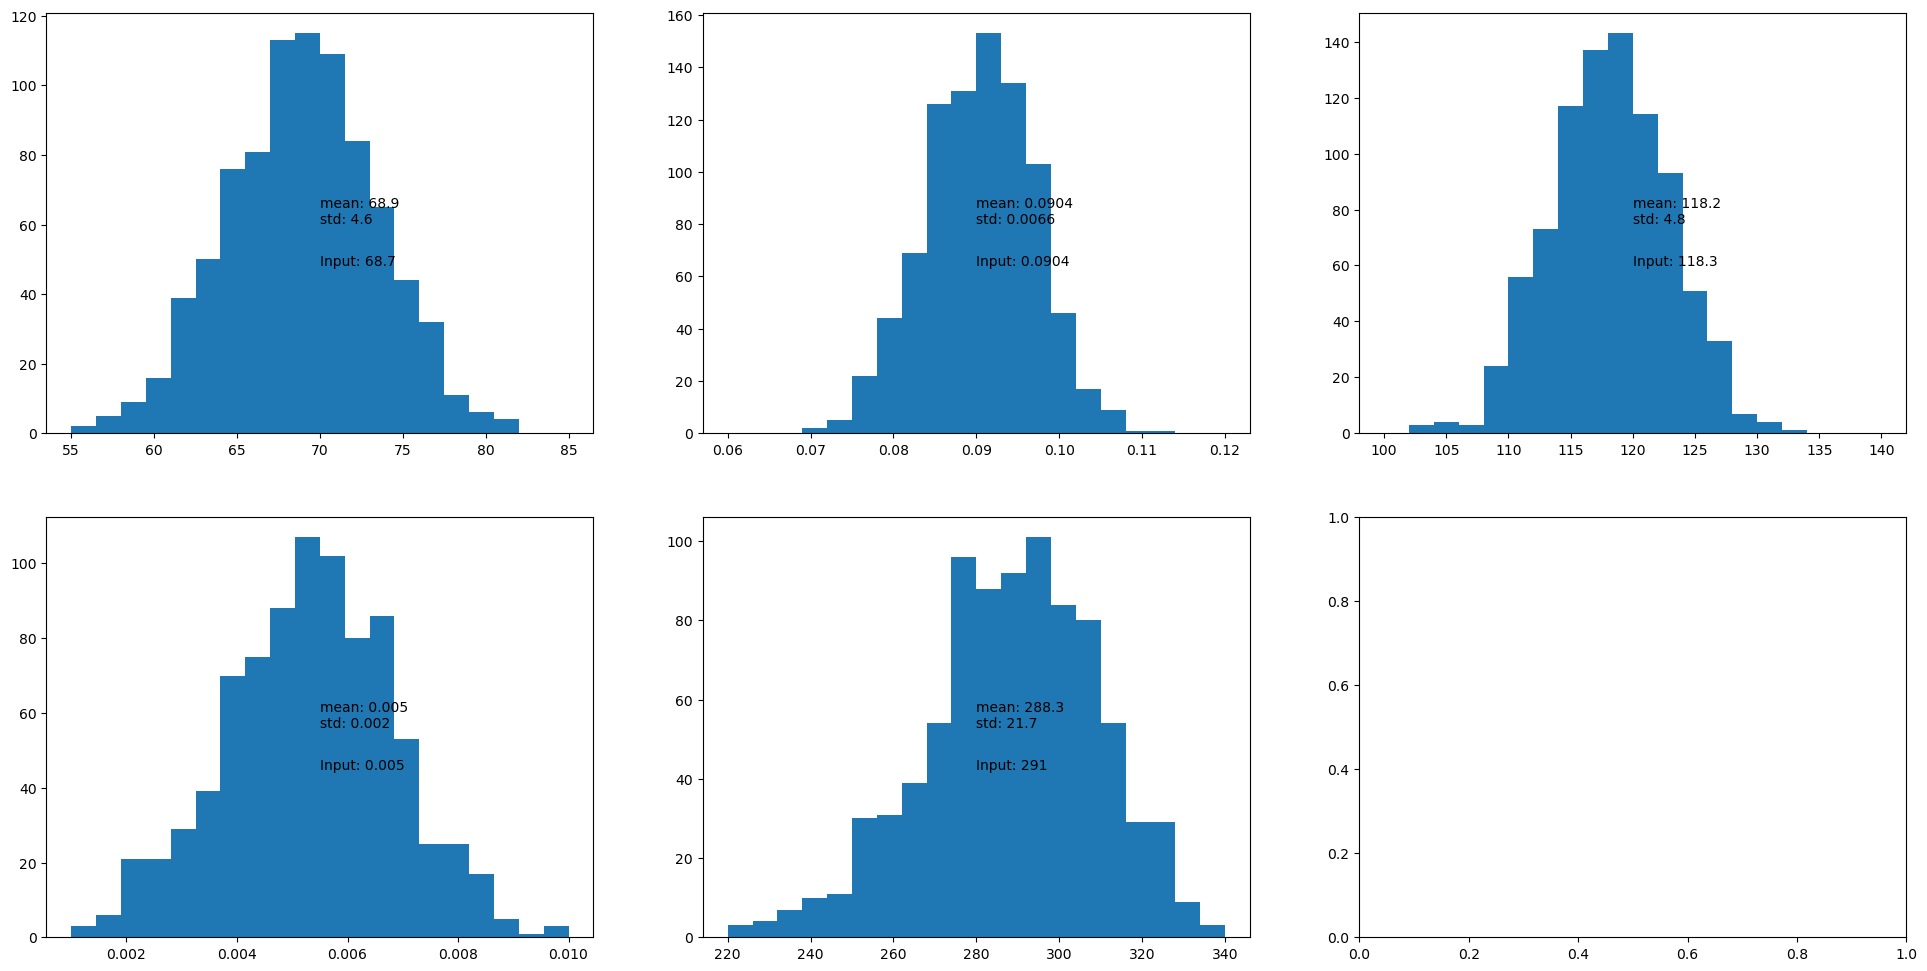

In [48]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(8*3, 6*2))

ax1.hist(gamma, bins=20, range=(55, 85), label="gamma")
ax1.text(0.5, 0.5, f"mean: {np.mean(gamma):.1f}\nstd: {np.std(gamma):.1f}",
            transform=ax1.transAxes)
ax1.text(0.5, 0.4, "Input: 68.7", transform=ax1.transAxes)

ax2.hist(rB_dk, bins=20, range=(0.06, 0.12), label="rB_dk")
ax2.text(0.5, 0.5, f"mean: {np.mean(rB_dk):.4f}\nstd: {np.std(rB_dk):.4f}",
            transform=ax2.transAxes)
ax2.text(0.5, 0.4, "Input: 0.0904", transform=ax2.transAxes)

ax3.hist(dB_dk, bins=20, range=(100, 140), label="dB_dk")
ax3.text(0.5, 0.5, f"mean: {np.mean(dB_dk):.1f}\nstd: {np.std(dB_dk):.1f}",
            transform=ax3.transAxes)
ax3.text(0.5, 0.4, "Input: 118.3", transform=ax3.transAxes)


ax4.hist(rB_dpi, bins=20, range=(0.001, 0.01), label="rB_dpi")
ax4.text(0.5, 0.5, f"mean: {np.mean(rB_dpi):.3f}\nstd: {np.std(rB_dpi):.3f}",
            transform=ax4.transAxes)
ax4.text(0.5, 0.4, "Input: 0.005", transform=ax4.transAxes)

ax5.hist(dB_dpi, bins=20, range=(220, 340), label="dB_dpi")
ax5.text(0.5, 0.5, f"mean: {np.mean(dB_dpi):.1f}\nstd: {np.std(dB_dpi):.1f}",
            transform=ax5.transAxes)
ax5.text(0.5, 0.4, "Input: 291", transform=ax5.transAxes)




In [44]:
logfile = "/dice/users/pc24403/BPGGSZ/sim_fit_new/nohup.out"
time_arr=[]
with open(logfile) as f:
    for l in f:
        if "Total time" in l:
            a=l.split()
            time_arr.append(float(a[2]))


In [45]:
time_arr_gpu = [arr for arr in time_arr if arr < 300]
time_arr_cpu = [arr for arr in time_arr if arr > 300]

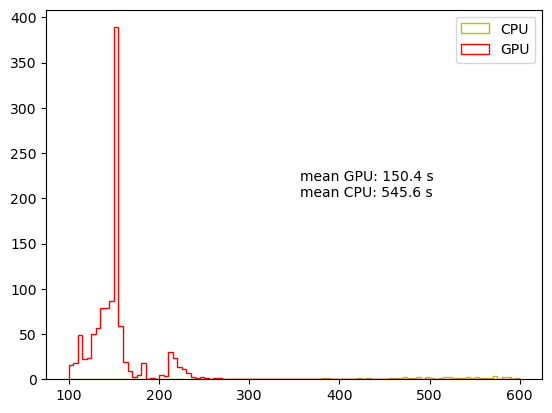

In [46]:
plt.hist([time_arr_gpu, time_arr_cpu] ,range=[100, 600],bins=100, color=["r", 'y'], histtype='step', label=['GPU', 'CPU'])
plt.text(-1.2, 0.2, f"mean GPU: {np.mean(time_arr_gpu):.1f} s\nmean CPU: {np.mean(time_arr_cpu):.1f} s",
            transform=ax5.transAxes)
plt.legend()